<a href="https://colab.research.google.com/github/eaboussouan/controlnet/blob/main/process_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.7 MB/s eta 0:00:00


To process different conditionings depending on the chosen ControlNet, we also need to install some
additional dependencies:
- [OpenCV](https://opencv.org/)
- [controlnet-aux](https://github.com/patrickvonplaten/controlnet_aux#controlnet-auxiliary-models) - a simple collection of pre-processing models for ControlNet

In [3]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.7 MB/s eta 0:00:00


In [4]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# image = load_image(
#     "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
# )
# image

Error caught was: No module named 'triton'
/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


Next, we will put the image through the canny pre-processor:

In [5]:
import cv2
from PIL import Image
import numpy as np

# image = np.array(image)

# low_threshold = 100
# high_threshold = 200

# image = cv2.Canny(image, low_threshold, high_threshold)
# image = image[:, :, None]
# image = np.concatenate([image, image, image], axis=2)
# canny_image = Image.fromarray(image)
# canny_image

As we can see, it is essentially edge detection.

Now, we load [runwaylml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5) as well as the [ControlNet model for canny edges](https://huggingface.co/lllyasviel/sd-controlnet-canny). The models are loaded in half-precision (`torch.dtype`) to allow for fast and memory-efficient inference.

In [6]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [156]:
print(type(controlnet))

<class 'diffusers.models.controlnet.ControlNetModel'>


Instead of using Stable Diffusion's default [PNDMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm), we use one of the currently fastest
diffusion model schedulers, called [UniPCMultistepScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/unipc).
Choosing an improved scheduler can drastically reduce inference time - in our case we are able to reduce the number of inference steps from 50 to 20 while more or less
keeping the same image generation quality. More information regarding schedulers can be found [here](https://huggingface.co/docs/diffusers/main/en/using-diffusers/schedulers).

In [7]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [8]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Instead of loading our pipeline directly to GPU, we instead enable smart CPU offloading which
can be achieved with the [`enable_model_cpu_offload` function](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet#diffusers.StableDiffusionControlNetPipeline.enable_model_cpu_offload).

Remember that during inference diffusion models, such as Stable Diffusion require not just one but multiple model components that are run sequentially.
In the case of Stable Diffusion with ControlNet, we first use the CLIP text encoder, then the diffusion model unet and control net, then the VAE decoder and finally run a safety checker.
Most components are only run once during the diffusion process and are thus not required to occupy GPU memory all the time. By enabling smart model offloading, we make sure
that each component is only loaded into GPU when it's needed so that we can significantly save memory consumption without significantly slowing down infenence.

**Note**: When running `enable_model_cpu_offload`, do not manually move the pipeline to GPU with `.to("cuda")` - once CPU offloading is enabled, the pipeline automatically takes care of GPU memory management.

In [9]:
pipe.enable_model_cpu_offload()

Finally, we want to take full advantage of the amazing [FlashAttention/xformers](https://github.com/facebookresearch/xformers) attention layer acceleration, so let's enable this! If this command does not work for you, you might not have `xformers` correctly installed.
In this case, you can just skip the following line of code.

In [10]:
pipe.enable_xformers_memory_efficient_attention()

Now we are ready to run the ControlNet pipeline!

We still provide a prompt to guide the image generation process, just like what we would normally do with a Stable Diffusion image-to-image pipeline. However, ControlNet will allow a lot more control over the generated image because we will be able to control the exact composition in generated image with the canny edge image we just created.

It will be fun to see some images where contemporary celebrities posing for this exact same painting from the 17th century. And it's really easy to do that with ControlNet, all we have to do is to include the names of these celebrities in the prompt!

In [11]:
model_id = "sd-dreambooth-library/mr-potato-head"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [12]:
# generator = torch.manual_seed(2)
# prompt = "a photo of sks mr potato head, best quality, extremely detailed"
# output = pipe(
#     prompt,
#     canny_image,
#     negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
#     generator=generator,
#     num_inference_steps=20,
# )

Let's create a [Open Pose ControlNet](https://huggingface.co/lllyasviel/sd-controlnet-openpose). We will generate some super-hero images but in the first frame pose shown above.


In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
!pwd

/content


In [15]:
%cd /content/drive/MyDrive/d


/content/drive/MyDrive/d


In [16]:
# cap.release()

In [17]:
import cv2
from google.colab.patches import cv2_imshow
# Replace 'my_video.mp4' with the name of your video file
cap = cv2.VideoCapture('flip.mp4')

# Read the first frame of the video
ret, frame = cap.read()
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)


# Define variables for frame count and frame interval
count = 0
processed_count = 0
max_count = min(frame_count,400)
interval = 1
images = [frame] * max_count

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # If the frame was not read successfully, exit the loop
    if not ret:
        break

    # Increment the frame count
    count += 1
    # If the current frame is a multiple of the frame interval, process it
    if count % interval == 0:

        # Process the current frame here
        images[processed_count] = frame

        # Increment the processed frame count
        processed_count += 1

        # If the desired number of frames has been processed, exit the loop
        if processed_count >= max_count:
            break

# Release the video capture object and close all windows
cap.release()


59


#Save poses

In [18]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in images]

cuda


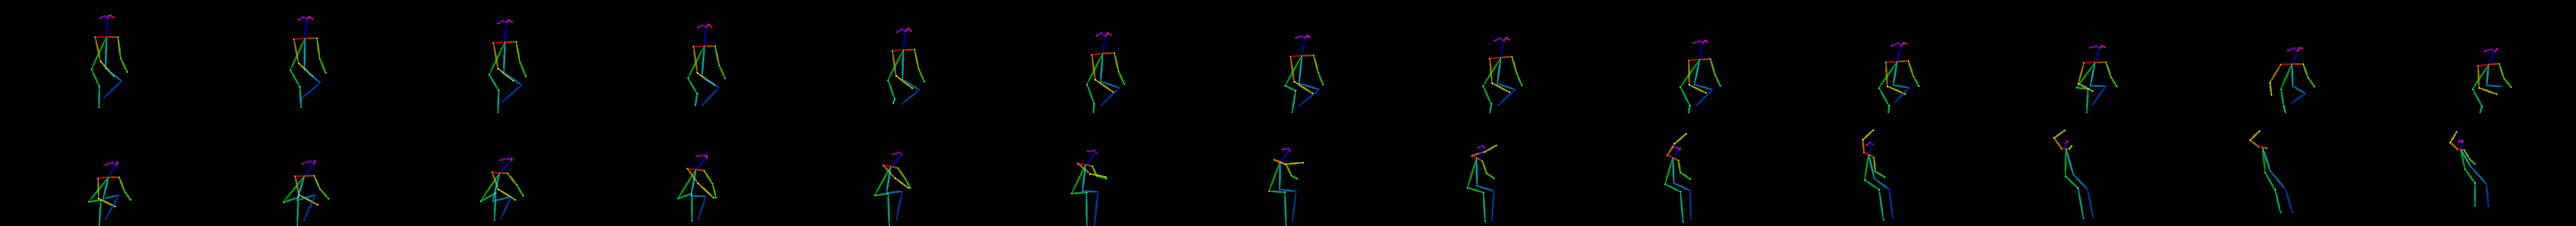

In [19]:
image_grid(poses[:26], 2, 13)

In [20]:
import pickle
file_name = 'poses.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(poses, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "poses.pkl"


# Use control net to generate first frame with prompt

In [21]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe_1 = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe_1.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe_1.enable_model_cpu_offload()
pipe_1.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

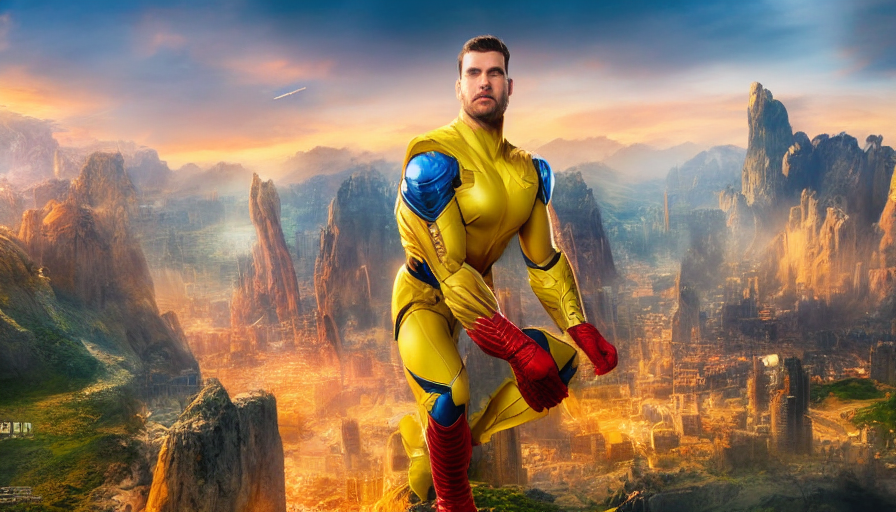

In [22]:
generator = torch.Generator(device="cpu").manual_seed(3)
prompt = "male super-hero character in futuristic landscape, best quality, extremely detailed, realistic face"
output = pipe_1(
    [prompt],
    poses[0],
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"],
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 1, 1)

In [23]:
# save a image using extension
output.images[0].save("seed_im.jpg")

# Title modify controlnet to take in seed image (im2im)

In [1]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch


In [182]:
class StableDiffusionControlNetPipelineWithSeed(StableDiffusionControlNetPipeline):
  from typing import Callable, List, Optional, Union, Dict, Any
  import PIL
  import pdb

  # def custom_prepare_latents(self, image, timestep, batch_size, num_images_per_prompt, dtype, device, generator=None):
  #     if not isinstance(image, (torch.Tensor, PIL.Image.Image, list)):
  #         raise ValueError(
  #             f"`image` has to be of type `torch.Tensor`, `PIL.Image.Image` or list but is {type(image)}"
  #         )

  #     image = image.to(device=device, dtype=dtype)

  #     batch_size = batch_size * num_images_per_prompt
  #     if isinstance(generator, list) and len(generator) != batch_size:
  #         raise ValueError(
  #             f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
  #             f" size of {batch_size}. Make sure the batch size matches the length of the generators."
  #         )

  #     if isinstance(generator, list):
  #         init_latents = [
  #             self.vae.encode(image[i : i + 1]).latent_dist.sample(generator[i]) for i in range(batch_size)
  #         ]
  #         init_latents = torch.cat(init_latents, dim=0)
  #     else:
  #         init_latents = self.vae.encode(image).latent_dist.sample(generator)

  #     init_latents = self.vae.config.scaling_factor * init_latents

  #     if batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] == 0:
  #         # expand init_latents for batch_size
  #         deprecation_message = (
  #             f"You have passed {batch_size} text prompts (`prompt`), but only {init_latents.shape[0]} initial"
  #             " images (`image`). Initial images are now duplicating to match the number of text prompts. Note"
  #             " that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update"
  #             " your script to pass as many initial images as text prompts to suppress this warning."
  #         )
  #         deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)
  #         additional_image_per_prompt = batch_size // init_latents.shape[0]
  #         init_latents = torch.cat([init_latents] * additional_image_per_prompt, dim=0)
  #     elif batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] != 0:
  #         raise ValueError(
  #             f"Cannot duplicate `image` of batch size {init_latents.shape[0]} to {batch_size} text prompts."
  #         )
  #     else:
  #         init_latents = torch.cat([init_latents], dim=0)

  #     shape = init_latents.shape
  #     noise = randn_tensor(shape, generator=generator, device=device, dtype=dtype)

  #     # get latents
  #     init_latents = self.scheduler.add_noise(init_latents, noise, timestep)
  #     latents = init_latents

  #     return latents

  # @torch.no_grad()
  # # @replace_example_docstring(EXAMPLE_DOC_STRING)
  # def __call__(
  #       self,
  #       prompt: Union[str, List[str]] = None,
  #       image: Union[torch.FloatTensor, PIL.Image.Image, List[torch.FloatTensor], List[PIL.Image.Image]] = None,
  #       height: Optional[int] = None,
  #       width: Optional[int] = None,
  #       num_inference_steps: int = 50,
  #       guidance_scale: float = 7.5,
  #       negative_prompt: Optional[Union[str, List[str]]] = None,
  #       num_images_per_prompt: Optional[int] = 1,
  #       eta: float = 0.0,
  #       generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
  #       latents: Optional[torch.FloatTensor] = None,
  #       prompt_embeds: Optional[torch.FloatTensor] = None,
  #       negative_prompt_embeds: Optional[torch.FloatTensor] = None,
  #       output_type: Optional[str] = "pil",
  #       return_dict: bool = True,
  #       callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
  #       callback_steps: int = 1,
  #       cross_attention_kwargs: Optional[Dict[str, Any]] = None,
  #       controlnet_conditioning_scale: float = 1.0,
  #   ):
  #       r"""
  #       Function invoked when calling the pipeline for generation.

  #       Args:
  #           prompt (`str` or `List[str]`, *optional*):
  #               The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
  #               instead.
  #           image (`torch.FloatTensor`, `PIL.Image.Image`, `List[torch.FloatTensor]` or `List[PIL.Image.Image]`):
  #               The ControlNet input condition. ControlNet uses this input condition to generate guidance to Unet. If
  #               the type is specified as `Torch.FloatTensor`, it is passed to ControlNet as is. PIL.Image.Image` can
  #               also be accepted as an image. The control image is automatically resized to fit the output image.
  #           height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
  #               The height in pixels of the generated image.
  #           width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
  #               The width in pixels of the generated image.
  #           num_inference_steps (`int`, *optional*, defaults to 50):
  #               The number of denoising steps. More denoising steps usually lead to a higher quality image at the
  #               expense of slower inference.
  #           guidance_scale (`float`, *optional*, defaults to 7.5):
  #               Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
  #               `guidance_scale` is defined as `w` of equation 2. of [Imagen
  #               Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
  #               1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
  #               usually at the expense of lower image quality.
  #           negative_prompt (`str` or `List[str]`, *optional*):
  #               The prompt or prompts not to guide the image generation. If not defined, one has to pass
  #               `negative_prompt_embeds`. instead. If not defined, one has to pass `negative_prompt_embeds`. instead.
  #               Ignored when not using guidance (i.e., ignored if `guidance_scale` is less than `1`).
  #           num_images_per_prompt (`int`, *optional*, defaults to 1):
  #               The number of images to generate per prompt.
  #           eta (`float`, *optional*, defaults to 0.0):
  #               Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
  #               [`schedulers.DDIMScheduler`], will be ignored for others.
  #           generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
  #               One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
  #               to make generation deterministic.
  #           latents (`torch.FloatTensor`, *optional*):
  #               Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
  #               generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
  #               tensor will ge generated by sampling using the supplied random `generator`.
  #           prompt_embeds (`torch.FloatTensor`, *optional*):
  #               Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
  #               provided, text embeddings will be generated from `prompt` input argument.
  #           negative_prompt_embeds (`torch.FloatTensor`, *optional*):
  #               Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
  #               weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
  #               argument.
  #           output_type (`str`, *optional*, defaults to `"pil"`):
  #               The output format of the generate image. Choose between
  #               [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
  #           return_dict (`bool`, *optional*, defaults to `True`):
  #               Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
  #               plain tuple.
  #           callback (`Callable`, *optional*):
  #               A function that will be called every `callback_steps` steps during inference. The function will be
  #               called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
  #           callback_steps (`int`, *optional*, defaults to 1):
  #               The frequency at which the `callback` function will be called. If not specified, the callback will be
  #               called at every step.
  #           cross_attention_kwargs (`dict`, *optional*):
  #               A kwargs dictionary that if specified is passed along to the `AttnProcessor` as defined under
  #               `self.processor` in
  #               [diffusers.cross_attention](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/cross_attention.py).
  #           controlnet_conditioning_scale (`float`, *optional*, defaults to 1.0):
  #               The outputs of the controlnet are multiplied by `controlnet_conditioning_scale` before they are added
  #               to the residual in the original unet.

  #       Examples:

  #       Returns:
  #           [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
  #           [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
  #           When returning a tuple, the first element is a list with the generated images, and the second element is a
  #           list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
  #           (nsfw) content, according to the `safety_checker`.
  #       """
  #       # 0. Default height and width to unet
  #       height, width = self._default_height_width(height, width, image)

  #       # 1. Check inputs. Raise error if not correct
  #       self.check_inputs(
  #           prompt, image, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
  #       )

  #       # 2. Define call parameters
  #       if prompt is not None and isinstance(prompt, str):
  #           batch_size = 1
  #       elif prompt is not None and isinstance(prompt, list):
  #           batch_size = len(prompt)
  #       else:
  #           batch_size = prompt_embeds.shape[0]

  #       device = self._execution_device
  #       # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
  #       # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
  #       # corresponds to doing no classifier free guidance.
  #       do_classifier_free_guidance = guidance_scale > 1.0

  #       # 3. Encode input prompt
  #       prompt_embeds = self._encode_prompt(
  #           prompt,
  #           device,
  #           num_images_per_prompt,
  #           do_classifier_free_guidance,
  #           negative_prompt,
  #           prompt_embeds=prompt_embeds,
  #           negative_prompt_embeds=negative_prompt_embeds,
  #       )

  #       # 4. Prepare image
  #       image = self.prepare_image(
  #           image,
  #           width,
  #           height,
  #           batch_size * num_images_per_prompt,
  #           num_images_per_prompt,
  #           device,
  #           self.controlnet.dtype,
  #       )

  #       if do_classifier_free_guidance:
  #           image = torch.cat([image] * 2)

  #       # 5. Prepare timesteps
  #       self.scheduler.set_timesteps(num_inference_steps, device=device)
  #       timesteps = self.scheduler.timesteps

  #       # 6. Prepare latent variables
  #       num_channels_latents = self.unet.in_channels
  #       latents = self.prepare_latents(
  #           batch_size * num_images_per_prompt,
  #           num_channels_latents,
  #           height,
  #           width,
  #           prompt_embeds.dtype,
  #           device,
  #           generator,
  #           latents,
  #       )

  #       # 7. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
  #       extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

  #       # 8. Denoising loop
  #       num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
  #       with self.progress_bar(total=num_inference_steps) as progress_bar:
  #           for i, t in enumerate(timesteps):
  #               # expand the latents if we are doing classifier free guidance
  #               latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
  #               latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

  #               down_block_res_samples, mid_block_res_sample = self.controlnet(
  #                   latent_model_input,
  #                   t,
  #                   encoder_hidden_states=prompt_embeds,
  #                   controlnet_cond=image,
  #                   return_dict=False,
  #               )

  #               down_block_res_samples = [
  #                   down_block_res_sample * controlnet_conditioning_scale
  #                   for down_block_res_sample in down_block_res_samples
  #               ]
  #               mid_block_res_sample *= controlnet_conditioning_scale

  #               # predict the noise residual
  #               noise_pred = self.unet(
  #                   latent_model_input,
  #                   t,
  #                   encoder_hidden_states=prompt_embeds,
  #                   cross_attention_kwargs=cross_attention_kwargs,
  #                   down_block_additional_residuals=down_block_res_samples,
  #                   mid_block_additional_residual=mid_block_res_sample,
  #               ).sample

  #               # perform guidance
  #               if do_classifier_free_guidance:
  #                   noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  #                   noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  #               # compute the previous noisy sample x_t -> x_t-1
  #               latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

  #               # call the callback, if provided
  #               if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
  #                   progress_bar.update()
  #                   if callback is not None and i % callback_steps == 0:
  #                       callback(i, t, latents)

  #       # If we do sequential model offloading, let's offload unet and controlnet
  #       # manually for max memory savings
  #       if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
  #           self.unet.to("cpu")
  #           self.controlnet.to("cpu")
  #           torch.cuda.empty_cache()

  #       if output_type == "latent":
  #           image = latents
  #           has_nsfw_concept = None
  #       elif output_type == "pil":
  #           # 8. Post-processing
  #           image = self.decode_latents(latents)

  #           # 9. Run safety checker
  #           image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

  #           # 10. Convert to PIL
  #           image = self.numpy_to_pil(image)
  #       else:
  #           # 8. Post-processing
  #           image = self.decode_latents(latents)

  #           # 9. Run safety checker
  #           image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

  #       # Offload last model to CPU
  #       if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
  #           self.final_offload_hook.offload()

  #       if not return_dict:
  #           return (image, has_nsfw_concept)

  #       return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)


In [6]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

In [8]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe_im2im = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
# pipe_im2im.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe_im2im.enable_model_cpu_offload()
# pipe_im2im.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
# pipe_im2im.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe_im2im.enable_model_cpu_offload()
# pipe_im2im.enable_xformers_memory_efficient_attention()

In [9]:
generator = torch.Generator(device="cpu").manual_seed(3)
prompt = "male super-hero character in futuristic landscape, best quality, extremely detailed, realistic face"
output = pipe_im2im(
    [prompt],
    poses[2],

    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"],
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 1, 1)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'poses' is not defined

In [ ]:
@torch.no_grad()
  def __call__2(
      self,
      prompt: Union[str, List[str]] = None,
      image: Union[torch.FloatTensor, PIL.Image.Image, List[torch.FloatTensor], List[PIL.Image.Image]] = None,
      seed_image: PIL.Image.Image =None,
      height: Optional[int] = None,
      width: Optional[int] = None,
      num_inference_steps: int = 50,
      guidance_scale: float = 7.5,
      negative_prompt: Optional[Union[str, List[str]]] = None,
      num_images_per_prompt: Optional[int] = 1,
      eta: float = 0.0,
      generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
      latents: Optional[torch.FloatTensor] = None,
      prompt_embeds: Optional[torch.FloatTensor] = None,
      negative_prompt_embeds: Optional[torch.FloatTensor] = None,
      output_type: Optional[str] = "pil",
      return_dict: bool = True,
      callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
      callback_steps: int = 1,
      cross_attention_kwargs: Optional[Dict[str, Any]] = None,
      controlnet_conditioning_scale: Union[float, List[float]] = 1.0,
  ):
      r"""
      Function invoked when calling the pipeline for generation.
      Args:
          prompt (`str` or `List[str]`, *optional*):
              The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
              instead.
          image (`torch.FloatTensor`, `PIL.Image.Image`, `List[torch.FloatTensor]`, `List[PIL.Image.Image]`,
                  `List[List[torch.FloatTensor]]`, or `List[List[PIL.Image.Image]]`):
              The ControlNet input condition. ControlNet uses this input condition to generate guidance to Unet. If
              the type is specified as `Torch.FloatTensor`, it is passed to ControlNet as is. `PIL.Image.Image` can
              also be accepted as an image. The dimensions of the output image defaults to `image`'s dimensions. If
              height and/or width are passed, `image` is resized according to them. If multiple ControlNets are
              specified in init, images must be passed as a list such that each element of the list can be correctly
              batched for input to a single controlnet.
          height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
              The height in pixels of the generated image.
          width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
              The width in pixels of the generated image.
          num_inference_steps (`int`, *optional*, defaults to 50):
              The number of denoising steps. More denoising steps usually lead to a higher quality image at the
              expense of slower inference.
          guidance_scale (`float`, *optional*, defaults to 7.5):
              Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
              `guidance_scale` is defined as `w` of equation 2. of [Imagen
              Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
              1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
              usually at the expense of lower image quality.
          negative_prompt (`str` or `List[str]`, *optional*):
              The prompt or prompts not to guide the image generation. If not defined, one has to pass
              `negative_prompt_embeds`. instead. If not defined, one has to pass `negative_prompt_embeds`. instead.
              Ignored when not using guidance (i.e., ignored if `guidance_scale` is less than `1`).
          num_images_per_prompt (`int`, *optional*, defaults to 1):
              The number of images to generate per prompt.
          eta (`float`, *optional*, defaults to 0.0):
              Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
              [`schedulers.DDIMScheduler`], will be ignored for others.
          generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
              One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
              to make generation deterministic.
          latents (`torch.FloatTensor`, *optional*):
              Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
              generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
              tensor will ge generated by sampling using the supplied random `generator`.
          prompt_embeds (`torch.FloatTensor`, *optional*):
              Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
              provided, text embeddings will be generated from `prompt` input argument.
          negative_prompt_embeds (`torch.FloatTensor`, *optional*):
              Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
              weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
              argument.
          output_type (`str`, *optional*, defaults to `"pil"`):
              The output format of the generate image. Choose between
              [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
          return_dict (`bool`, *optional*, defaults to `True`):
              Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
              plain tuple.
          callback (`Callable`, *optional*):
              A function that will be called every `callback_steps` steps during inference. The function will be
              called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
          callback_steps (`int`, *optional*, defaults to 1):
              The frequency at which the `callback` function will be called. If not specified, the callback will be
              called at every step.
          cross_attention_kwargs (`dict`, *optional*):
              A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
              `self.processor` in
              [diffusers.cross_attention](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/cross_attention.py).
          controlnet_conditioning_scale (`float` or `List[float]`, *optional*, defaults to 1.0):
              The outputs of the controlnet are multiplied by `controlnet_conditioning_scale` before they are added
              to the residual in the original unet. If multiple ControlNets are specified in init, you can set the
              corresponding scale as a list.
      Examples:
      Returns:
          [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
          [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
          When returning a tuple, the first element is a list with the generated images, and the second element is a
          list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
          (nsfw) content, according to the `safety_checker`.
      """
      # 0. Default height and width to unet
      height, width = self._default_height_width(height, width, image)

      # 1. Check inputs. Raise error if not correct

      # Why does this fail?
      # self.check_inputs(
      #     prompt,
      #     image,
      #     height,
      #     width,
      #     callback_steps,
      #     negative_prompt,
      #     prompt_embeds,
      #     negative_prompt_embeds,
      #     controlnet_conditioning_scale,
      # )

      # 2. Define call parameters
      if prompt is not None and isinstance(prompt, str):
          batch_size = 1
      elif prompt is not None and isinstance(prompt, list):
          batch_size = len(prompt)
      else:
          batch_size = prompt_embeds.shape[0]

      device = self._execution_device
      # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
      # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
      # corresponds to doing no classifier free guidance.
      do_classifier_free_guidance = guidance_scale > 1.0

      # TODO TRY
      # if isinstance(self.controlnet, MultiControlNetModel) and isinstance(controlnet_conditioning_scale, float):
      #   controlnet_conditioning_scale = [controlnet_conditioning_scale] * len(self.controlnet.nets)

      # 3. Encode input prompt
      # import pdb
      # pdb.set_trace()
      prompt_embeds = self._encode_prompt(
          prompt,
          device,
          num_images_per_prompt,
          do_classifier_free_guidance,
          negative_prompt,
          prompt_embeds=prompt_embeds,
          negative_prompt_embeds=negative_prompt_embeds,
      )

      # 4. Prepare image
      if isinstance(self.controlnet, ControlNetModel):
          image = self.prepare_image(
              image=image,
              width=width,
              height=height,
              batch_size=batch_size * num_images_per_prompt,
              num_images_per_prompt=num_images_per_prompt,
              device=device,
              dtype=self.controlnet.dtype,
              do_classifier_free_guidance=do_classifier_free_guidance,
          )
      elif isinstance(self.controlnet, StableDiffusionControlNetPipeline.MultiControlNetModel):
          images = []

          for image_ in image:
              image_ = self.prepare_image(
                  image=image_,
                  width=width,
                  height=height,
                  batch_size=batch_size * num_images_per_prompt,
                  num_images_per_prompt=num_images_per_prompt,
                  device=device,
                  dtype=self.controlnet.dtype,
                  do_classifier_free_guidance=do_classifier_free_guidance,
              )

              images.append(image_)

          image = images
      else:
          assert False
      seed_image = [seed_image]

      # 5. Prepare timesteps
      self.scheduler.set_timesteps(num_inference_steps, device=device)
      timesteps = self.scheduler.timesteps
      latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

      # 6. Prepare latent variables
      # num_channels_latents = self.unet.in_channels
      # latents = self.prepare_latents(
      #     batch_size * num_images_per_prompt,
      #     num_channels_latents,
      #     height,
      #     width,
      #     prompt_embeds.dtype,
      #     device,
      #     generator,
      #     latents,
      # )
      latents = self.prepare_latents(
            seed_image, latent_timestep, batch_size, num_images_per_prompt, prompt_embeds.dtype, device, generator
      )

      # 7. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
      extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

      # 8. Denoising loop
      num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
      with self.progress_bar(total=num_inference_steps) as progress_bar:
          for i, t in enumerate(timesteps):
              # expand the latents if we are doing classifier free guidance
              latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
              latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

              # controlnet(s) inference
              down_block_res_samples, mid_block_res_sample = self.controlnet(
                  latent_model_input,
                  t,
                  encoder_hidden_states=prompt_embeds,
                  controlnet_cond=image,
                  conditioning_scale=controlnet_conditioning_scale,
                  return_dict=False,
              )

              # predict the noise residual
              noise_pred = self.unet(
                  latent_model_input,
                  t,
                  encoder_hidden_states=prompt_embeds,
                  cross_attention_kwargs=cross_attention_kwargs,
                  down_block_additional_residuals=down_block_res_samples,
                  mid_block_additional_residual=mid_block_res_sample,
              ).sample

              # perform guidance
              if do_classifier_free_guidance:
                  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

              # compute the previous noisy sample x_t -> x_t-1
              latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

              # call the callback, if provided
              if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                  progress_bar.update()
                  if callback is not None and i % callback_steps == 0:
                      callback(i, t, latents)

      # If we do sequential model offloading, let's offload unet and controlnet
      # manually for max memory savings
      if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
          self.unet.to("cpu")
          self.controlnet.to("cpu")
          torch.cuda.empty_cache()

      if output_type == "latent":
          image = latents
          has_nsfw_concept = None
      elif output_type == "pil":
          # 8. Post-processing
          image = self.decode_latents(latents)

          # 9. Run safety checker
          image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

          # 10. Convert to PIL
          image = self.numpy_to_pil(image)
      else:
          # 8. Post-processing
          image = self.decode_latents(latents)

          # 9. Run safety checker
          image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

      # Offload last model to CPU
      if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
          self.final_offload_hook.offload()

      if not return_dict:
          return (image, has_nsfw_concept)

      return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept) 